Best parameters found: {'regressor__colsample_bytree': 0.7797802696552814, 'regressor__learning_rate': 0.038623034947123394, 'regressor__max_depth': 9, 'regressor__n_estimators': 161, 'regressor__subsample': 0.7300733288106989}
Mean Absolute Error: 11.83
Root Mean Squared Error: 13.64
R^2 Score: -0.07


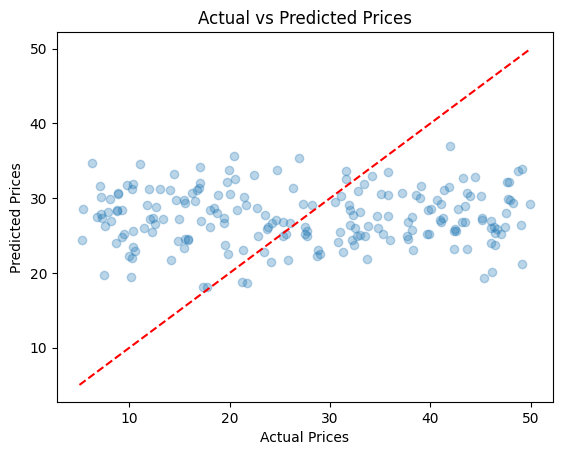

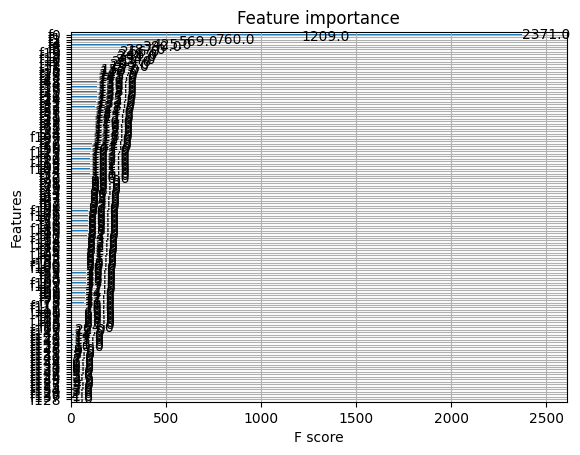

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint

# Mock data generation
np.random.seed(42)
num_samples = 1000

# Time-related factors
times_of_day = np.random.choice(['morning', 'afternoon', 'evening', 'night'], num_samples)
days_of_week = np.random.choice(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], num_samples)
months_of_year = np.random.choice(['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], num_samples)
seasons = np.random.choice(['spring', 'summer', 'fall', 'winter'], num_samples)
holidays = np.random.choice([0, 1], num_samples)  # 0 for no holiday, 1 for holiday

# Location-related factors
pickup_locations = np.random.choice(['residential', 'commercial', 'entertainment'], num_samples)
dropoff_locations = np.random.choice(['residential', 'commercial', 'entertainment'], num_samples)
distances = np.random.uniform(1, 30, num_samples)  # in kilometers
population_density = np.random.uniform(1000, 10000, num_samples)

# Weather conditions
weather = np.random.choice(['sunny', 'rainy', 'snowy'], num_samples)
temperature = np.random.uniform(-10, 35, num_samples)  # in Celsius
humidity = np.random.uniform(30, 90, num_samples)  # in percentage
wind_speed = np.random.uniform(0, 20, num_samples)  # in km/h

# Traffic conditions
traffic_congestion = np.random.uniform(0, 100, num_samples)  # congestion level
road_closures = np.random.choice([0, 1], num_samples)  # 0 for no closure, 1 for closure

# Demand-related factors
ride_requests = np.random.randint(1, 100, num_samples)
passenger_cancellation_rate = np.random.uniform(0, 0.5, num_samples)

# Supply-related factors
available_drivers = np.random.randint(1, 50, num_samples)
driver_ratings = np.random.uniform(1, 5, num_samples)

# Competitor pricing
competitor_prices = np.random.uniform(5, 50, num_samples)

# Historical data
historical_prices = np.random.uniform(5, 50, num_samples)

# External factors
events = np.random.choice([0, 1], num_samples)  # 0 for no event, 1 for event

# User behavior
user_response_to_price = np.random.uniform(0, 1, num_samples)

# Other factors
fuel_prices = np.random.uniform(1, 5, num_samples)  # in dollars per liter

# Target variable: Price
prices = np.random.uniform(5, 50, num_samples)

# Combine into a DataFrame
data = pd.DataFrame({
    'times_of_day': times_of_day,
    'days_of_week': days_of_week,
    'months_of_year': months_of_year,
    'seasons': seasons,
    'holidays': holidays,
    'pickup_locations': pickup_locations,
    'dropoff_locations': dropoff_locations,
    'distances': distances,
    'population_density': population_density,
    'weather': weather,
    'temperature': temperature,
    'humidity': humidity,
    'wind_speed': wind_speed,
    'traffic_congestion': traffic_congestion,
    'road_closures': road_closures,
    'ride_requests': ride_requests,
    'passenger_cancellation_rate': passenger_cancellation_rate,
    'available_drivers': available_drivers,
    'driver_ratings': driver_ratings,
    'competitor_prices': competitor_prices,
    'historical_prices': historical_prices,
    'events': events,
    'user_response_to_price': user_response_to_price,
    'fuel_prices': fuel_prices,
    'prices': prices
})

# One-hot encode categorical features
categorical_features = ['times_of_day', 'days_of_week', 'months_of_year', 'seasons', 'pickup_locations', 'dropoff_locations', 'weather']
numerical_features = ['distances', 'population_density', 'temperature', 'humidity', 'wind_speed', 'traffic_congestion', 'ride_requests', 'passenger_cancellation_rate', 'available_drivers', 'driver_ratings', 'competitor_prices', 'historical_prices', 'user_response_to_price', 'fuel_prices']

# Add polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('scale', StandardScaler()), ('poly', poly)]), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Split data into training and testing sets
X = data.drop('prices', axis=1)
y = data['prices']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with preprocessing and XGBoost regressor
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'regressor__n_estimators': randint(100, 500),
    'regressor__learning_rate': uniform(0.01, 0.3),
    'regressor__max_depth': randint(3, 10),
    'regressor__subsample': uniform(0.6, 0.4),
    'regressor__colsample_bytree': uniform(0.6, 0.4)
}

random_search = RandomizedSearchCV(pipeline, param_dist, n_iter=100, cv=5, scoring='neg_mean_absolute_error', random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

print(f'Best parameters found: {random_search.best_params_}')
best_model = random_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'R^2 Score: {r2:.2f}')

# Plot predicted vs actual prices
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices')
plt.show()

# Plot feature importance
model = best_model.named_steps['regressor']
xgb.plot_importance(model, importance_type='weight')
plt.show()
